# Project 2 – Section 2.2
## Up-and-out European Call option
This notebook implements the numerical tasks of Section 2.2:

1. Crude Monte Carlo estimator for the up-and-out European Call.
2. Importance sampling strategy via drift modification (r → r_tilde).
3. PDE-based optimal control importance sampling with barrier.
4. Repetition for a tighter barrier U = 170 with fine PDE discretization.

Parameter values (Section 2.2):
- T = 0.2
- K = 150
- sigma = 0.3
- U = 200 (later also U = 170)
- r = 0.1
- S0 = 100
- EM discretization: M = 1000

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from math import log, sqrt, exp
from scipy.stats import norm 
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import RegularGridInterpolator

import plotly.graph_objects as go
from tqdm import tqdm


## Global parameters and payoff

Up-and-out European Call payoff:
$
\psi(\{S(t)\}_{t \in [0,T]}) =
e^{-rT} (S(T) - K)^+ \mathbf{1}_{\{\max_{t \in [0,T]} S(t) \le U\}}.
$

In [29]:
# Parameters for Section 2.2
T_22 = 0.2
K_22 = 150.0
sigma_22 = 0.3
r_22 = 0.1
S0_22 = 100.0
U_22 = 200.0

M_path = 1000
dt_path = T_22 / M_path
sqrt_dt_path = np.sqrt(dt_path)

def payoff_up_and_out_vectored(S_paths, K, r, T, U):
    """
    Vectorized Up-and-out European Call payoff.
    S_paths: array of shape (N, M+1)
    """
    S_T = S_paths[:, -1]
    max_S = np.max(S_paths, axis=1)
    
    not_knocked_out = max_S <= U
    standard_payoffs = np.exp(-r * T) * np.maximum(S_T - K, 0)
    final_payoffs = np.where(not_knocked_out, standard_payoffs, 0.0)
    
    number_knocked_out = np.sum(~not_knocked_out)
    number_over_strike = np.sum(S_T > K)
    
    return final_payoffs, number_knocked_out, number_over_strike


## Euler–Maruyama simulation for GBM paths
SDE:

$
dS(t) = r S(t)\,dt + \sigma S(t)\,dW(t),
$

discretized as:

$
S_{m+1} = S_m + r S_m \Delta t + \sigma S_m \Delta W_m,\quad
\Delta W_m \sim \mathcal{N}(0, \Delta t).
$

In [30]:
def simulate_gbm_em_paths_vectored(N, S0, r, sigma, T, M):
    """
    Vectored simulation of N GBM paths using Euler-Maruyama.
    """
    dt = T / M
    sqrt_dt = np.sqrt(dt)
    
    S_paths = np.zeros((N, M + 1))
    S_paths[:, 0] = S0
    
    for m in range(M):
        dW = np.random.normal(0, sqrt_dt, size=N)
        S_paths[:, m + 1] = S_paths[:, m] + (r * S_paths[:, m] * dt) + (sigma * S_paths[:, m] * dW)
    
    return S_paths


## 2.2.1 Crude Monte Carlo

- Simulate N paths of the GBM with EM and M=1000.
- Evaluate the up-and-out payoff on each path.
- Compute the crude Monte Carlo estimator and its standard deviation.

N=10: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=16: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=26: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=42: Estimate=0.119906, Std=0.777083, Over Strike=1, Knocked Out=0
N=69: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=112: Estimate=0.190425, Std=2.015270, Over Strike=1, Knocked Out=0
N=183: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=297: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=483: Estimate=0.006985, Std=0.153515, Over Strike=1, Knocked Out=0
N=784: Estimate=0.009352, Std=0.261859, Over Strike=1, Knocked Out=0
N=1274: Estimate=0.012329, Std=0.322935, Over Strike=2, Knocked Out=0
N=2069: Estimate=0.002200, Std=0.100060, Over Strike=1, Knocked Out=0
N=3359: Estimate=0.017112, Std=0.411169, Over Strike=9, Knocked Out=0
N=5455: Estimate=0.002519, Std=0.152662, Over Strike=2, Knocked Out=0
N=8858: Estimate=0.001700, Std=0.08

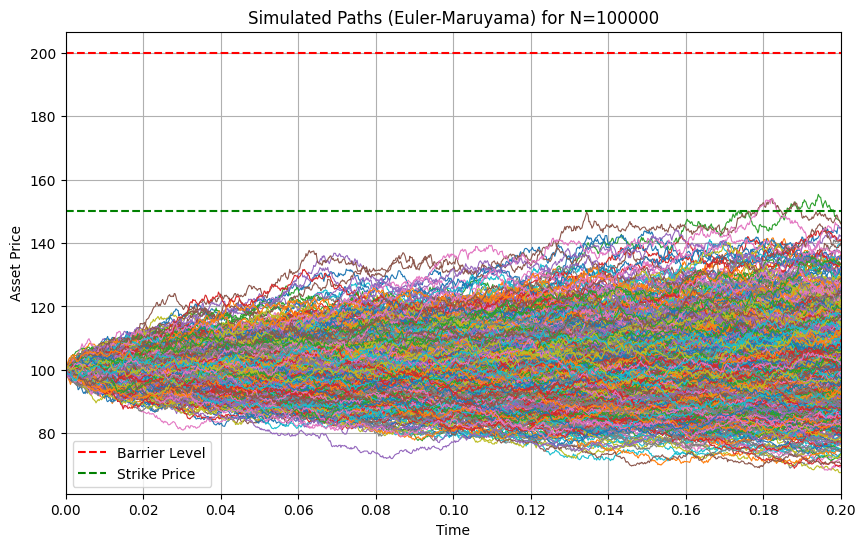

In [31]:
def mc_up_and_out_crude_vectored(N, S0, r, sigma, T, K, U, M):
    """
    Vectored Crude MC estimator for the up-and-out European Call.
    """
    S_paths = simulate_gbm_em_paths_vectored(N, S0, r, sigma, T, M)
    payoffs, number_knocked_out, number_over_strike = payoff_up_and_out_vectored(S_paths, K, r, T, U)
    
    est = np.mean(payoffs)
    std = np.std(payoffs, ddof=1)
    
    return est, std, S_paths, payoffs, number_knocked_out, number_over_strike


n_range = np.logspace(1, 5, num=20, dtype=int)
mc_results_22 = []

for N in n_range:
    est, std, S_paths, payoffs, number_knocked_out, number_over_strike = mc_up_and_out_crude_vectored(N, S0_22, r_22, sigma_22, T_22, K_22, U_22, M_path)
    print(f"N={N}: Estimate={est:.6f}, Std={std:.6f}, Over Strike={number_over_strike}, Knocked Out={number_knocked_out}")
    mc_results_22.append((N, est, std, S_paths, payoffs, number_knocked_out, number_over_strike))

n_vals = np.array([res[0] for res in mc_results_22])
estimates = np.array([res[1] for res in mc_results_22])
stds = np.array([res[2] for res in mc_results_22])
lower_errs = estimates - 1.96 * stds / np.sqrt(n_vals)
upper_errs = estimates + 1.96 * stds / np.sqrt(n_vals)
res_knocked = np.array([res[5] for res in mc_results_22])
res_strike = np.array([res[6] for res in mc_results_22])


labels=[f"{T_22/10*i:.2f}" for i in range(11)]
plt.figure(figsize=(10,6))
for i in range(min(N,1000)):
    plt.plot(mc_results_22[-1][3][i], lw=0.8)
plt.axhline(U_22, color='red', linestyle='--', label='Barrier Level')
plt.axhline(K_22, color='green', linestyle='--', label='Strike Price')
plt.title(f"Simulated Paths (Euler-Maruyama) for N={mc_results_22[-1][0]}")
plt.xlabel("Time")
plt.ylabel("Asset Price")
plt.xlim(0, M_path)
plt.xticks(np.linspace(0, M_path, 11), labels=[f"{T_22/10*i:.2f}" for i in range(11)])
plt.legend()
plt.grid()
plt.show()

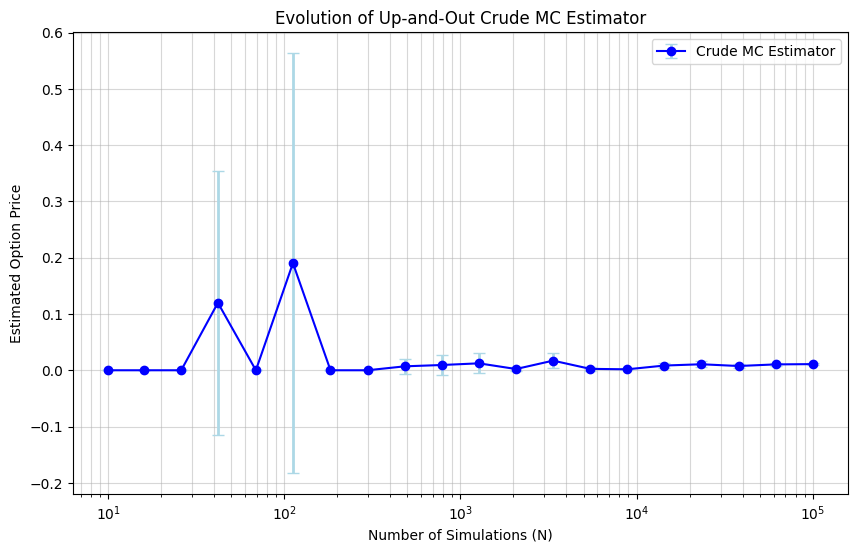

Number of Knocked Out Paths (N=100000): 0
Number of Paths Over Strike (N=100000): 173


In [32]:
yerr = np.array([estimates - lower_errs, upper_errs - estimates])
plt.figure(figsize=(10, 6))
plt.errorbar(n_vals, estimates, yerr=yerr, fmt='-o', color='b', ecolor='lightblue', elinewidth=2, capsize=4, label='Crude MC Estimator')
plt.xscale('log')
plt.xlabel('Number of Simulations (N)')
plt.ylabel('Estimated Option Price')
plt.title('Evolution of Up-and-Out Crude MC Estimator')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

print(f"Number of Knocked Out Paths (N={n_vals[-1]}): {res_knocked[-1]}")
print(f"Number of Paths Over Strike (N={n_vals[-1]}): {res_strike[-1]}")

## 2.2.2 Importance Sampling via drift modification

We simulate the GBM under drift $\tilde{r}$, track the Brownian increments $\Delta W$,
and reweight with the pathwise Girsanov factor:

$
w = \exp\left(-\theta \tilde W_T + \frac{1}{2}\theta^2 T\right),
\qquad \theta = \frac{r - \tilde{r}}{\sigma}.
$

Estimator:
$
\hat{Z}_{\text{IS}} =
\frac{1}{N}\sum_{i=1}^N \psi(\text{path}^{(i)}) w^{(i)}.
$

### Grid-based adaptive selection of $\tilde{r}$

For a given sample size N_base:
- Loop over $\tilde{r}$ in a grid.
- For each $\tilde{r}$, estimate the IS variance.
- Select the $\tilde{r}$ with minimal estimated variance.

Then, with this $\tilde{r}^*$, we can increase N until a desired CI half-width is achieved.

In [ ]:
def simulate_fixed_rtilde_is(S0, K, r, sigma, T, U, M, N, r_tilde, random_seed=123):
    """
    Simulates paths with a fixed r_tilde to observe the effect on 
    Strike hits and Barrier knock-outs.
    Based on the Algorithm 6.7 in the lecture notes.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    dt = T / M
    sqrt_dt = np.sqrt(dt)
    
    W_T_paths = np.zeros(N)
    S_paths = np.ones((N, M + 1)) * S0
    
    for m in range(M):
        dW = np.random.normal(0, sqrt_dt, size=N)
        S_paths[:, m+1] = S_paths[:, m] + (r_tilde * S_paths[:, m] * dt) + \
                          (sigma * S_paths[:, m] * dW)
        W_T_paths += dW

    payoffs, num_knocked, num_strike = payoff_up_and_out_vectored(S_paths, K, r, T, U)
    
    theta = (r - r_tilde) / sigma
    weights = np.exp(-theta * W_T_paths - 0.5 * (theta**2) * T)
    
    weighted_payoffs = payoffs * weights
    estimate = np.mean(weighted_payoffs)
    std_err = np.std(weighted_payoffs, ddof=1) / np.sqrt(N)
    
    return {
        "estimate": estimate,
        "std_err": std_err,
        "num_strike": num_strike,
        "num_knocked": num_knocked,
        "S_paths": S_paths
    }

r_values = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]
N_samples = 100_000

all_res = []
for rt in r_values:
    res = simulate_fixed_rtilde_is(S0_22, K_22, r_22, sigma_22, T_22, U_22, M_path, N_samples, rt)
    all_res.append(res)
    print(f"r_tilde: {rt:.2f} | Strike Hits: {res['num_strike']} | Knock-outs: {res['num_knocked']} | Est: {res['estimate']:.6f} | StdErr: {res['std_err']:.6f}")


r_tilde: 0.00 | Strike Hits: 90 | Knock-outs: 0 | Est: 0.003635 | StdErr: 0.000521
r_tilde: 0.50 | Strike Hits: 920 | Knock-outs: 3 | Est: 0.310408 | StdErr: 0.017679
r_tilde: 1.00 | Strike Hits: 5485 | Knock-outs: 16 | Est: 5.290077 | StdErr: 0.163465
r_tilde: 1.50 | Strike Hits: 19701 | Knock-outs: 165 | Est: 16.198172 | StdErr: 0.321840
r_tilde: 2.00 | Strike Hits: 45827 | Knock-outs: 1512 | Est: 8.474218 | StdErr: 0.114879
r_tilde: 2.50 | Strike Hits: 73898 | Knock-outs: 7775 | Est: 0.619988 | StdErr: 0.005974
r_tilde: 3.00 | Strike Hits: 91647 | Knock-outs: 24942 | Est: 0.005944 | StdErr: 0.000048
r_tilde: 4.00 | Strike Hits: 99807 | Knock-outs: 79045 | Est: 0.000000 | StdErr: 0.000000


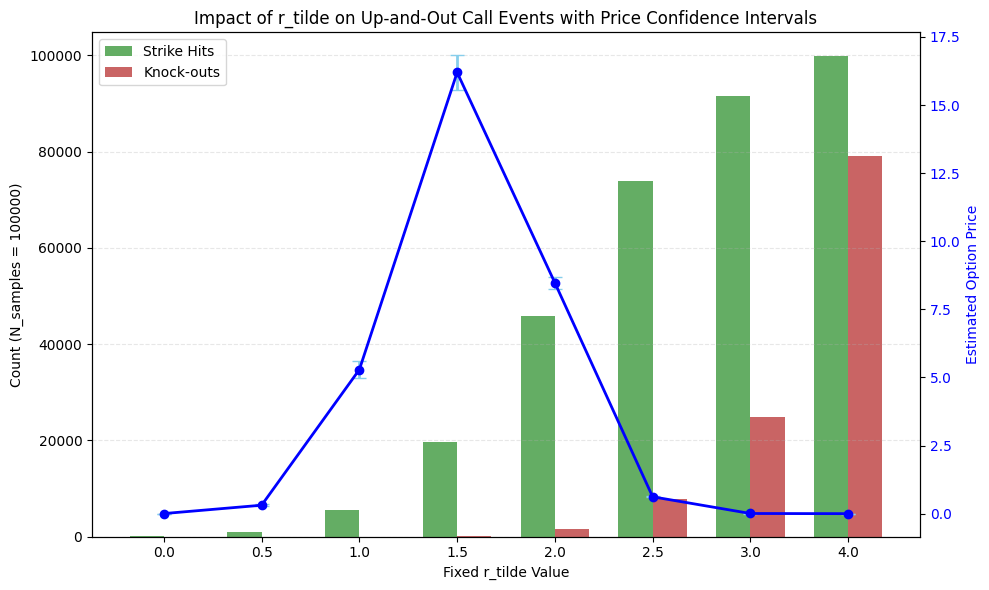

In [34]:
strike_hits = [res['num_strike'] for res in all_res]
knock_outs = [res['num_knocked'] for res in all_res]
estimates = [res['estimate'] for res in all_res]

errors = [1.96 * res['std_err'] for res in all_res]
r_labels = [f"{rt:.1f}" for rt in r_values]

x = np.arange(len(r_labels))
width = 0.35
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(x - width/2, strike_hits, width, label='Strike Hits', color='forestgreen', alpha=0.7)
ax1.bar(x + width/2, knock_outs, width, label='Knock-outs', color='firebrick', alpha=0.7)
ax1.set_xlabel('Fixed r_tilde Value')
ax1.set_ylabel(f'Count (N_samples = {N_samples})')
ax1.set_title('Impact of r_tilde on Up-and-Out Call Events with Price Confidence Intervals')
ax1.set_xticks(x)
ax1.set_xticklabels(r_labels)
ax1.legend(loc='upper left')
ax1.grid(axis='y', linestyle='--', alpha=0.3)

ax2 = ax1.twinx()
ax2.errorbar(x, estimates, yerr=errors, fmt='-o', color='blue', ecolor='skyblue', 
             elinewidth=2, capsize=5, linewidth=2, label='Price Estimate (95% CI)')
ax2.set_ylabel('Estimated Option Price', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
fig.tight_layout()
plt.show()

We observe that, depending on $\tilde{r}$, the paths are steered towards the strike price, and ultimately the barrier. There is a tradeoff between a low $\tilde{r}$ where almost no paths result in a positive payoff, and a high $\tilde{r}$ where most of the paths hit the barrier, giving a 0 payoff.

In [ ]:
def adaptive_is_up_and_out_rtilde(
    S0, K, r, sigma, T, U, M,
    tol=1e-3, alpha=0.05,
    N_bar=1000, gamma=2.0,
    r_min=0.1, r_max=5.0,
    n_grid=50,
    n_refine=201,
    refine_half_width=0.25,
    max_iter=20,
    random_seed=123
):
    """
    Adaptive IS for up-and-out European Call option using r_tilde optimization, 
    following Algorithm 6.4/6.7.

    The minimization is performed via a two-stage grid search, 
    first minimizing the empirical J(theta) over a course grid, then refining around the best candidate.  
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    c = norm.ppf(1 - alpha / 2.0)
    dt = T / M
    
    # Initialize 
    N = int(N_bar / gamma)
    r_tilde = r_min
    sigma_hat = np.inf

    history = {"r_tilde": [], "N": [], "Z_hat": [], "sigma_hat": []}

    for it in range(max_iter):
        halfwidth = c * sigma_hat / np.sqrt(N)
        print(f"Iteration {it+1}: N={N}, r_tilde={r_tilde:.4f}, sigma_hat={sigma_hat:.6f}")
        print(f"  Current tolerance check (half-width vs tol): {halfwidth:.6f} <= {tol:.6f}")
        
        if halfwidth <= tol: 
            print(f"\n** Tolerance achieved at iteration {it} **")
            break

        N = int(gamma * N)
        
        # We track the sum of dW to compute the Girsanov likelihood ratio
        W_T_paths = np.zeros(N)
        S_paths = np.ones((N, M + 1)) * S0
        sqrt_dt = np.sqrt(dt)
        
        for m in range(M):
            dW = np.random.normal(0, sqrt_dt, size=N)
            S_paths[:, m+1] = S_paths[:, m] + (r_tilde * S_paths[:, m] * dt) + (sigma * S_paths[:, m] * dW)
            W_T_paths += dW

        payoffs, num_knocked, num_strike = payoff_up_and_out_vectored(S_paths, K, r, T, U)
        print(f"  Strike={num_strike}, Knocked={num_knocked}\n")
        
        # Likelihood ratio: L = exp(-theta * W_T - 0.5 * theta^2 * T)
        theta_curr = (r - r_tilde) / sigma
        w_curr = np.exp(-theta_curr * W_T_paths - 0.5 * (theta_curr**2) * T)
        weighted = payoffs * w_curr

        Z_hat = np.mean(weighted)
        sigma_hat = np.std(weighted, ddof=1)
        
        # Objective: minimize E[ (Payoff * L)^2 ]
        r_grid_coarse = np.linspace(r_min, r_max, n_grid)
        J_coarse = []
        
        for r_cand in r_grid_coarse:
            theta_cand = (r - r_cand) / sigma
            L_cand = np.exp(-theta_cand * W_T_paths - 0.5 * (theta_cand**2) * T)
            J_coarse.append(np.mean((payoffs * L_cand)**2))
        
        best_coarse = r_grid_coarse[np.argmin(J_coarse)]
        
        
        # Refinement
        lo = max(r_min, best_coarse - refine_half_width)
        hi = min(r_max, best_coarse + refine_half_width)
        r_grid_fine = np.linspace(lo, hi, n_refine)
        J_fine = [np.mean((payoffs * np.exp(-((r - rc)/sigma) * W_T_paths - 0.5*((r - rc)/sigma)**2 * T))**2) 
                    for rc in r_grid_fine]
            
        r_tilde = float(r_grid_fine[np.argmin(J_fine)])

        # Update History
        history["r_tilde"].append(r_tilde)
        history["N"].append(N)
        history["Z_hat"].append(Z_hat)
        history["sigma_hat"].append(sigma_hat)

    return {**history, "S_paths": S_paths, "final_strike": num_strike, "final_knocked": num_knocked}

In [36]:
adaptive_results_dict = adaptive_is_up_and_out_rtilde(
    S0=S0_22, K=K_22, r=r_22, sigma=sigma_22, T=T_22, U=U_22, M=M_path,
    r_min =1.5, r_max=2.5,
    tol=5e-2,
    alpha=0.05,
    N_bar=100_001,
    gamma=1.5
)

Iteration 1: N=66667, r_tilde=1.5000, sigma_hat=inf
  Current tolerance check (half-width vs tol): inf <= 0.050000
  Strike=19701, Knocked=165

Iteration 2: N=100000, r_tilde=2.5000, sigma_hat=101.774802
  Current tolerance check (half-width vs tol): 0.630795 <= 0.050000
  Strike=110675, Knocked=11606

Iteration 3: N=150000, r_tilde=2.5000, sigma_hat=1.893277
  Current tolerance check (half-width vs tol): 0.009581 <= 0.050000

** Tolerance achieved at iteration 2 **


Final IS Estimate: 0.621824
Final Std Error: 1.893277
Final r_tilde: 2.500000
Paths hitting Strike: 110675
Paths hitting Barrier: 11606


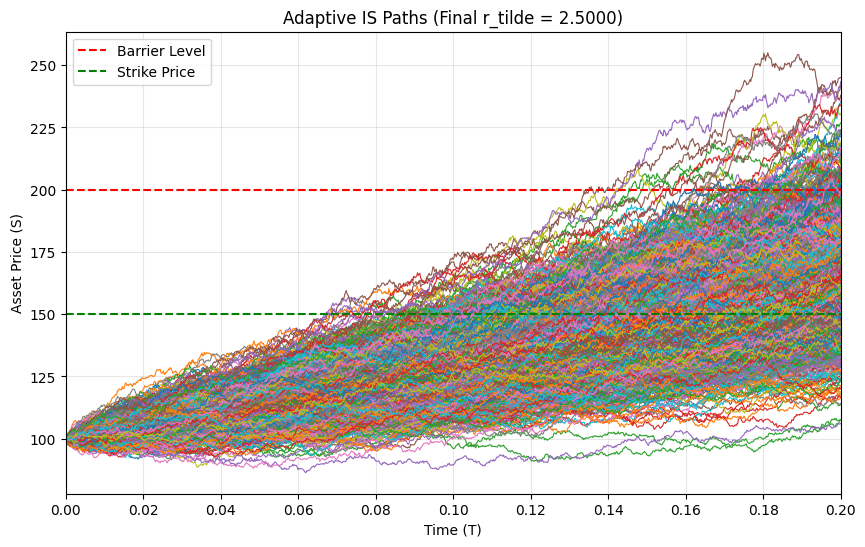

In [37]:
final_price = adaptive_results_dict["Z_hat"][-1]
final_std = adaptive_results_dict["sigma_hat"][-1]
final_paths = adaptive_results_dict["S_paths"]
n_knocked = adaptive_results_dict["final_knocked"]
n_strike = adaptive_results_dict["final_strike"]

print(f"Final IS Estimate: {final_price:.6f}")
print(f"Final Std Error: {final_std:.6f}")
print(f"Final r_tilde: {adaptive_results_dict['r_tilde'][-1]:.6f}")
print(f"Paths hitting Strike: {n_strike}")
print(f"Paths hitting Barrier: {n_knocked}")


labels = [f"{T_22/10*i:.2f}" for i in range(11)]
plt.figure(figsize=(10,6))
for i in range(min(len(final_paths), 1000)):
    plt.plot(final_paths[i], lw=0.8)
plt.axhline(U_22, color='red', linestyle='--', label='Barrier Level')
plt.axhline(K_22, color='green', linestyle='--', label='Strike Price')
plt.title(f"Adaptive IS Paths (Final r_tilde = {adaptive_results_dict['r_tilde'][-1]:.4f})")
plt.xlabel("Time (T)")
plt.ylabel("Asset Price (S)")
plt.xlim(0, M_path)
plt.xticks(np.linspace(0, M_path, 11), labels=labels)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Implementing an adaptive $\tilde{r}$ effectively steers the paths towards the strike price and the barrier, but we observe that a constant $\tilde{r}$ is not the optimal solution since, no matter the $[r_{min}, r_{max}]$ interval chosen for the adaptive algorithm, the optimal $\tilde{r}$ always ends up on an extremity.

For a low $\tilde{r}$, the payoffs are almost always 0 and the variance is very low, while for a high $\tilde{r}$, most of the paths are knocked out ang give a 0 payoff, resulting also in a very low variance.

## 2.2.3 PDE with barrier and optimal control $\zeta^*$
We solve the PDE

$\frac{\partial v}{\partial t} + rs \frac{dv}{ds} + \frac{1}{2}\sigma^2 s^2 \frac{\partial^2 v}{\partial s^2}$,

with:
- Final condition: $v(T, s) = (s - K)^+ e^{-rT}$.
- Spatial domain:
    - $S_\text{min}$ as in the Section 2.1 guideline: $S_\text{min} = S_0 \exp\{ (r- 0.5\sigma^2)T - 6 \sigma \sqrt{T} \}$,
    - $S_\text{max} = U$.
- Boundary conditions: $v(t, S_\text{min}) = 0, \quad v(t, S_\text{max}) = \varepsilon, \quad \varepsilon = 0.1$.

Again, we use implicit Euler in time and centered finite differences in space.



### Computing $\zeta^*(t,s)$ and interpolation

We compute:

$
\zeta^*(t,s) = \sigma s \frac{\partial}{\partial s} \log v(t,s),
$

with centered finite differences in $s$, boundary prolongation at $S_\text{min}$,
and zero control at t = T.

### Solving PDE and computing $\zeta^*$ for U = 200

Use a moderate grid, e.g. $P = 200$, $\tilde{M} = 200$, and then:
- plot $\zeta^*(t,s)$ on a restricted region for inspection,
- simulate controlled paths with this $\zeta^*$.

### Controlled SDE simulation and optimal-control IS estimator

## 2.2.4 Repeat with U = 170 and fine PDE discretization

- Barrier U = 170.
- PDE grid: P = 3000, M_tilde = 1500.
- Compute v(t,s), $\zeta^*(t,s)$.
- Optional: simulate controlled paths and compute IS estimator.